### Exploration of subtasks / methodology:

 - ### Caption sentiment class extraction
 - ### Caption sentiment classifier
 - ### Image feature extraction Pipeline: 
     - VGG-16
     - Inception
     - AlexNet
         - According to [google's dataset paper](https://www.aclweb.org/anthology/P18-1238.pdf) Inception_Resnet_v2 is best for feature extraction
 - ### Image object detection/ data
 - ### Object + Sentiment sentence generation
 - ### End to End model from tutorial
 - ### Caption evaluation pipeline:
     - BLEU score
     - Perplexity?
 

## Initial loading and displaying

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from utils import load_meta_data_from_dir
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [2]:
data_dir = '30k_sample'


In [3]:

image_captions,images_folder = load_meta_data_from_dir(data_dir)

In [4]:
#image_captions, images_folder = load_meta_data_from_dir(data_folder_name)

In [5]:
len(image_captions)

29928

In [6]:

#load a few sample images with captions
def display_samples(meta_df, num_samples=5, seed = 0):
    #sample num_sample rows from the dataframe
    samples = meta_df.sample(n=num_samples,random_state = 0)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        #get objects and confidence scores
        objects = row['objects'].split(',')
        confidences = row['object_confidences'].split(',')
        
        obj_conf = [str((obj,conf[0:4])) for obj,conf in zip(objects,confidences)]
        num_obj = len(obj_conf)
        obj_str = "\n".join(obj_conf)
        image = Image.open(file_name)
        fig = plt.figure(figsize=(10,(0.3*num_obj)))
        ax = fig.add_subplot(121)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image) 
        ax.set_title(caption)
        ax = fig.add_subplot(122)
        ax.text(0.1, 0.5, obj_str, horizontalalignment='left',verticalalignment='center')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        







In [7]:
#Add notebook relative file_path to image
image_captions['image_path'] = image_captions['global_index'].apply(lambda p: os.path.join(images_folder, str(p) + ".png"))

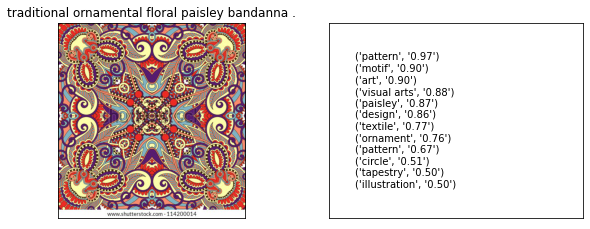

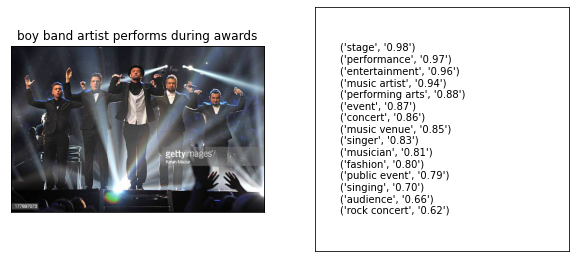

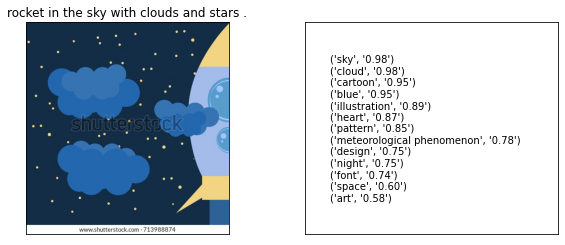

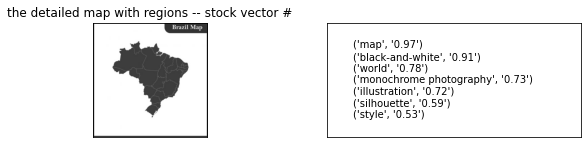

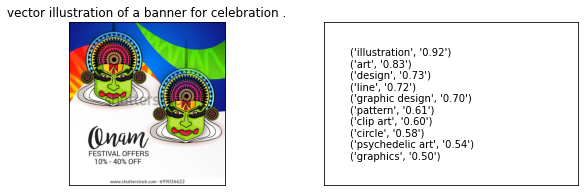

In [8]:
display_samples(image_captions)

## Profiling
- Size distribution of images
- Aspect Ration distribution of images: w/h
- Distribution of number of objects per image
- Distribution of number of objects at various confidence thresholds
- Distribution of caption size for each image

### Size distribution of images
This takes a while to run

In [10]:
image_captions['size'] = image_captions['image_path'].apply(lambda p: Image.open(p).size)
image_captions
image_captions.to_csv(os.path.join('data', data_dir,'prepped_meta'), index=False)

In [11]:
#number of different sizes:
image_captions['size'].describe()

count          29928
unique          8113
top       (450, 470)
freq            2749
Name: size, dtype: object

In [12]:
#profiling widths and heights
image_captions['height'] = image_captions['size'].apply(lambda x: x[1])
image_captions['width'] = image_captions['size'].apply(lambda x: x[0])

In [13]:
image_captions['height'].describe()


count    29928.000000
mean       666.933307
std        331.331541
min          1.000000
25%        470.000000
50%        600.000000
75%        736.000000
max       5472.000000
Name: height, dtype: float64

In [14]:
image_captions['width'].describe()

count    29928.000000
mean       713.737971
std        376.487763
min         80.000000
25%        459.000000
50%        612.000000
75%        800.000000
max       6016.000000
Name: width, dtype: float64

<AxesSubplot:ylabel='Frequency'>

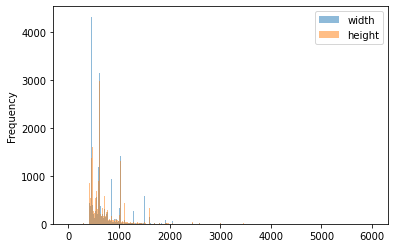

In [15]:
image_captions[['width','height']].plot.hist(bins = 500, alpha=0.5)

In [16]:
#looks like most images have a height and width under 1000 

In [17]:
quant = 0.9
print(image_captions['height'].quantile(quant))
print(image_captions['width'].quantile(quant))

1024.0
1024.0


In [18]:
q = np.linspace(.1, 1, 9, 0)
print(image_captions['height'].quantile(q))
print(image_captions['width'].quantile(q))

0.1     413.0
0.2     451.0
0.3     470.0
0.4     500.0
0.5     600.0
0.6     612.0
0.7     683.0
0.8     819.0
0.9    1024.0
Name: height, dtype: float64
0.1     441.0
0.2     450.0
0.3     500.0
0.4     600.0
0.5     612.0
0.6     670.0
0.7     736.0
0.8     852.0
0.9    1024.0
Name: width, dtype: float64


### Aspect ratio distribution of images

In [19]:
image_captions['aspect_ratio'] = image_captions.apply(lambda x: x.width/x.height , axis=1)

In [20]:
image_captions['aspect_ratio'].describe()

count    29928.000000
mean         1.205002
std         10.215326
min          0.500000
25%          0.766987
50%          1.000000
75%          1.478261
max       1250.000000
Name: aspect_ratio, dtype: float64

In [21]:
quant = 0.99
print(image_captions['aspect_ratio'].quantile(quant))

1.7808219178082192


<AxesSubplot:ylabel='Frequency'>

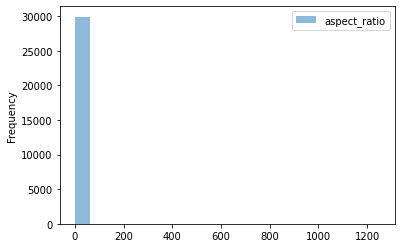

In [22]:
image_captions[['aspect_ratio']].plot.hist(bins=20, alpha=0.5)

### Number of objects per image

In [23]:
image_captions['num_obj'] = image_captions['objects'].apply(lambda o: 0 if pd.isna(o) else len(str(o).split(',')))

In [24]:
image_captions['num_obj'].describe()


count    29928.000000
mean        12.102112
std          3.626080
min          0.000000
25%          9.000000
50%         14.000000
75%         15.000000
max         15.000000
Name: num_obj, dtype: float64

In [25]:
image_captions['num_obj'].value_counts()


15    14706
9      1618
12     1589
10     1575
11     1555
8      1530
14     1451
13     1430
7      1264
6      1121
5       875
4       644
3       365
2       154
1        45
0         6
Name: num_obj, dtype: int64

All but 4 images have atleast 1 object in them and a maximum of 15 objects in them and around 50% of the images have 15 objects detected

<AxesSubplot:ylabel='Frequency'>

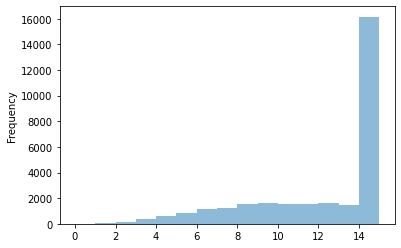

In [26]:
image_captions['num_obj'].plot.hist(bins=15, alpha=0.5)

### Distribution of num_objects at various confidence thresholds


In [32]:
def get_objects_with_conf_above(meta_df, threshold):
    """
    Returns a Series with a list of tuples (object,float) of object and confidence with confidence greater that threshold.
    """

    #object_conf tuple for objects with confidence above threshold
    obj_conf = image_captions.apply(lambda x: [] if (pd.isna(x.objects) or pd.isna(x.object_confidences))
                                   else [(obj,float(conf)) for (obj,conf) in zip(x.objects.split(','), x.object_confidences.split(',')) 
                                        if float(conf) >=threshold], axis=1)
    return obj_conf
    


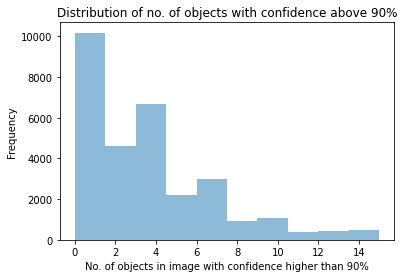

Number of images with atleast 1 caption with confidence higher than 90%: 24929


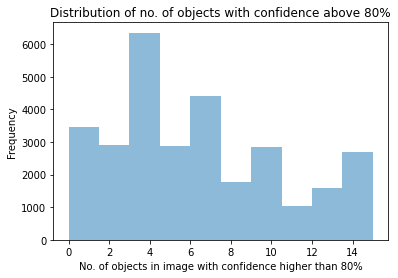

Number of images with atleast 1 caption with confidence higher than 80%: 28732


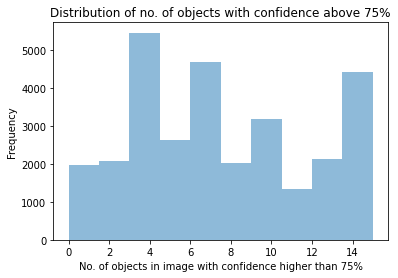

Number of images with atleast 1 caption with confidence higher than 75%: 29323


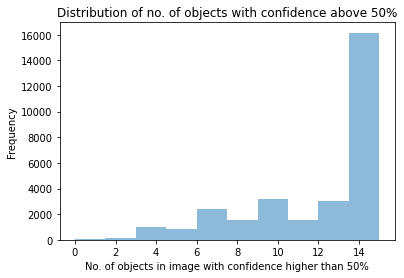

Number of images with atleast 1 caption with confidence higher than 50%: 29922


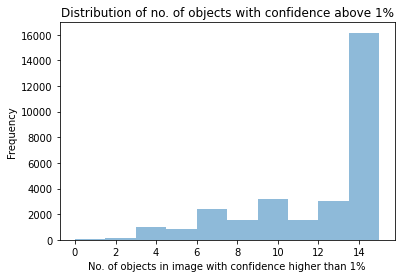

Number of images with atleast 1 caption with confidence higher than 1%: 29922


In [33]:
#get number of objects at various thresholds and plot them
thresholds = [90,80,75,50,1]
for t in thresholds:
    num_obj_conf = get_objects_with_conf_above(image_captions,(t*0.01)).apply(lambda l: len(l))
    num_obj_conf.plot.hist(alpha=0.5,title=f"Distribution of no. of objects with confidence above {t}%").set_xlabel(f"No. of objects in image with confidence higher than {t}%")
    plt.show()
    print(f"Number of images with atleast 1 caption with confidence higher than {t}%:",len(num_obj_conf[num_obj_conf > 0]))   


### Distribution of caption size

In [34]:
caption_size = image_captions['caption'].apply(lambda x: len(x.split(" ")))
caption_size.describe()

count    29928.000000
mean        10.247828
std          4.700695
min          5.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         49.000000
Name: caption, dtype: float64

<AxesSubplot:title={'center':'Distribution of caption size of image captions'}, ylabel='Frequency'>

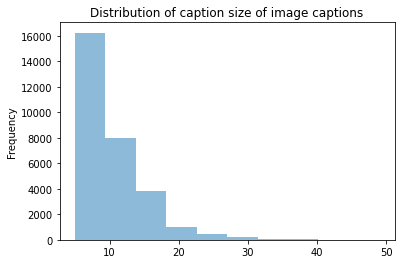

In [35]:
caption_size.plot.hist(alpha=0.5,title="Distribution of caption size of image captions")


In [36]:
caption_size.quantile([0.01,0.1,0.25,0.5,0.7,0.9,0.95, 0.99])


0.01     5.0
0.10     6.0
0.25     7.0
0.50     9.0
0.70    11.0
0.90    16.0
0.95    19.0
0.99    27.0
Name: caption, dtype: float64

All captions are more than 5 words and only 5% are above 20 words

## Divide captions into sentiment classes. 

 - nltk's pretrained SentimentIntensityAnalyser: sentiment and polarity
 - huggingface pretrained classifier

In [74]:
def display_samples_with_hf_label(meta_df, label, conf_thresh=0.9,num_samples=5, seed = 0, sent_class_col = 'hf_sent_class',sent_conf_col = 'hf_sent_conf' ):
    """
    Looking at positive and negative samples
    """
    #setting colors
    if("pos" in label.lower()):
        color = 'green'
    else:
        color = 'red'
    #filter to see high confidence examples of desired labels
    high_conf = meta_df[meta_df[sent_class_col] == label]
    high_conf = high_conf[high_conf[sent_conf_col] >= conf_thresh]
    #sample num_sample rows from the dataframe
    samples = high_conf.sample(n=num_samples,random_state = seed)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        #get objects and confidence scores
        objects = row['objects'].split(',')
        confidences = row['object_confidences'].split(',')
        sent_label_conf_str = (row[sent_class_col],str(row[sent_conf_col]))
        
        obj_conf = [str((obj,conf[0:4])) for obj,conf in zip(objects,confidences)]
        num_obj = len(obj_conf)
        obj_str = "\n".join(obj_conf)
        image = Image.open(file_name)
        fig = plt.figure(figsize=(20,(0.3*num_obj)))
        ax = fig.add_subplot(121)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image) 
        
        ax = fig.add_subplot(122)
        ax.text(0.1, 1, sent_label_conf_str, horizontalalignment='left',verticalalignment='top', fontsize = 11, color = color, bbox=dict(boxstyle = "square", color='white' ))
        
        ax.text(0.1, 0.5, obj_str, horizontalalignment='left',verticalalignment='center')
        plt.suptitle(caption)
        plt.xticks([])
        plt.yticks([])
        plt.show()

### NLTK's pretrained classifer and polarity scores

In [75]:
import nltk


In [76]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

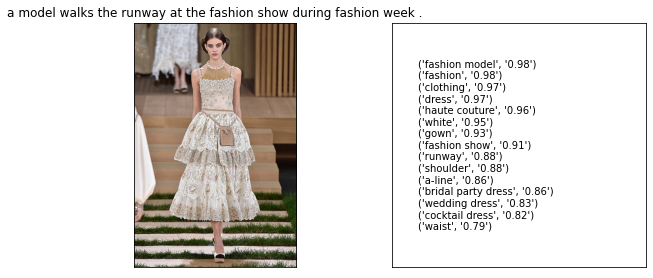

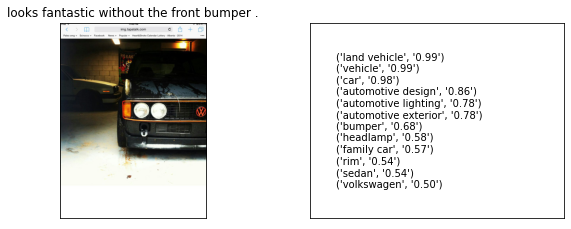

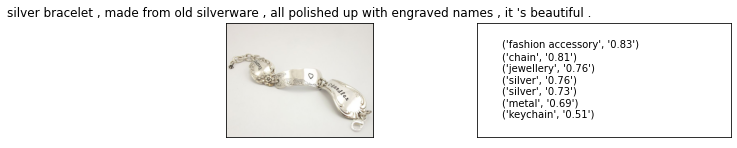

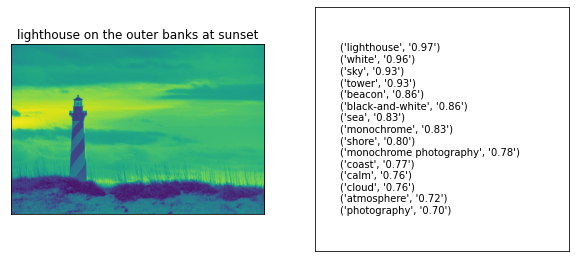

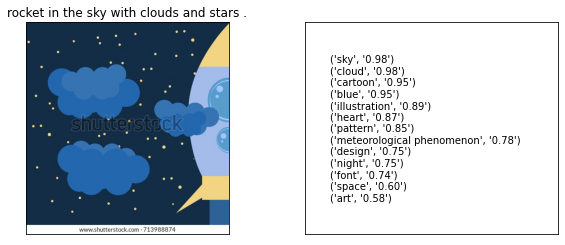

In [77]:
#example on random captions

random_sample = image_captions.sample(n=50, random_state=0)
display_samples(random_sample)

In [41]:
random_sample['nltk_sent_int'] = random_sample['caption'].apply(lambda x: sia.polarity_scores(x))
#classify using polarity scores: class with max polarity
random_sample['nltk_sent'] = random_sample['nltk_sent_int'].apply(lambda x: max(['neu', 'pos','neg'], key=x.get))
random_sample['nltk_sent'].value_counts() 

neu    50
Name: nltk_sent, dtype: int64

In [42]:
#now do this pfor everything and plot histogram of classes
image_captions['nltk_sent_polarity'] = image_captions['caption'].apply(lambda x: sia.polarity_scores(x))

In [43]:
image_captions['nltk_sent'] = image_captions['nltk_sent_polarity'].apply(lambda x: max(['neu', 'pos','neg'], key=x.get))

In [44]:
image_captions['nltk_sent'].describe()

count     29928
unique        3
top         neu
freq      29242
Name: nltk_sent, dtype: object

In [45]:
image_captions['nltk_sent'].value_counts()

neu    29242
pos      608
neg       78
Name: nltk_sent, dtype: int64

<AxesSubplot:>

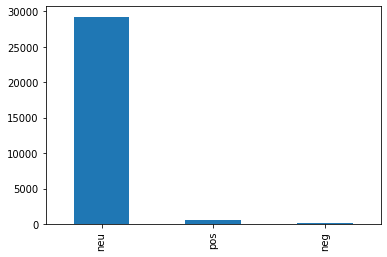

In [46]:
image_captions['nltk_sent'].value_counts().plot(kind='bar')

As we can see (and as expected), the overwhelming majority of captions are neutral

We can try limiting to the sentiment with max polarity among just positive and negative

In [47]:
image_captions['nltk_sent_pos_neg'] = image_captions['nltk_sent_polarity'].apply(lambda x: max(['pos','neg'], key=x.get))

In [48]:
image_captions['nltk_sent_pos_neg'].value_counts()

pos    27510
neg     2418
Name: nltk_sent_pos_neg, dtype: int64

<AxesSubplot:>

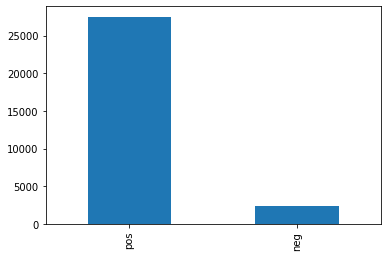

In [49]:
image_captions['nltk_sent_pos_neg'].value_counts().plot(kind='bar')

Still, classes are very unbalanced. 

In [50]:
image_captions['nltk_sent_pos_neg_conf'] = image_captions.apply(lambda x: x['nltk_sent_polarity'][x['nltk_sent_pos_neg']], axis=1)

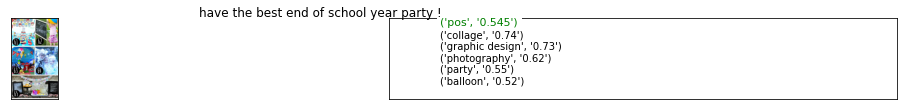

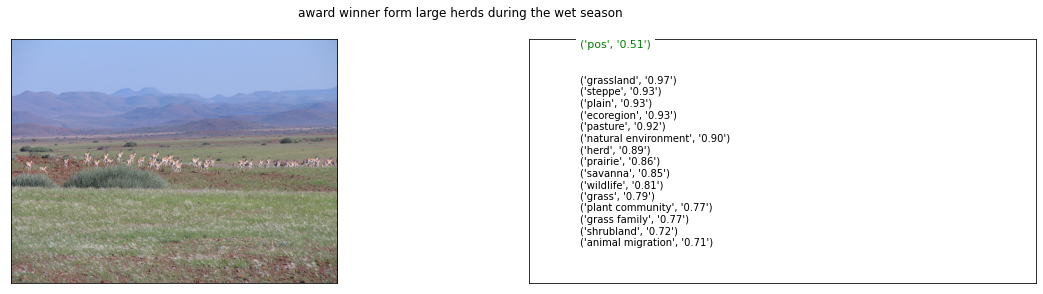

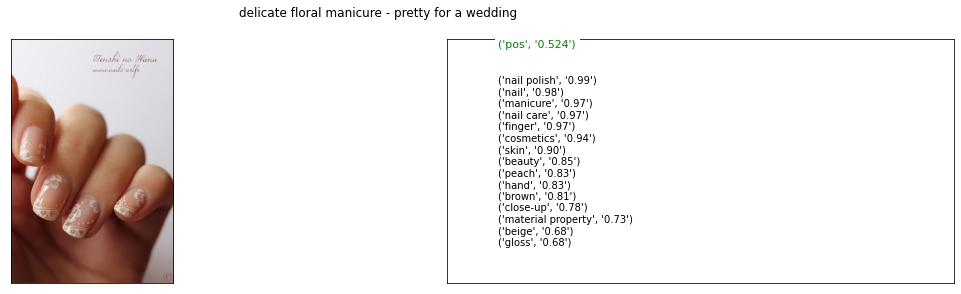

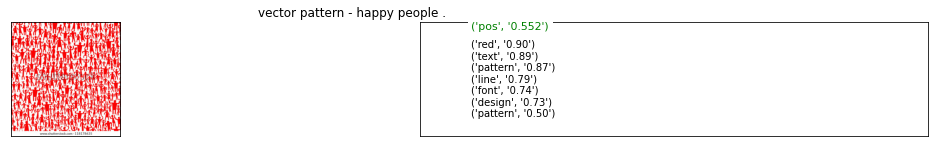

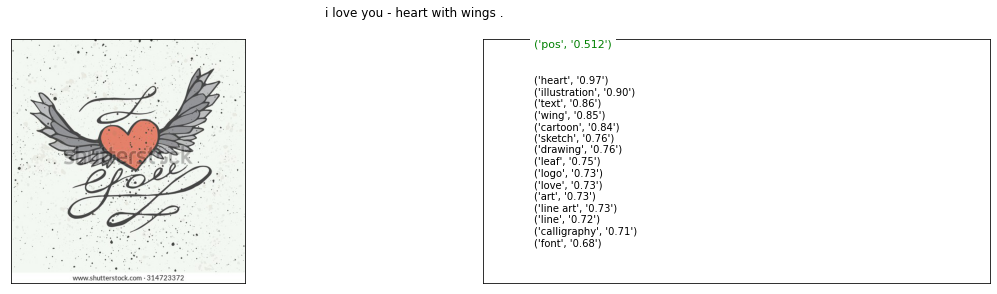

In [78]:
display_samples_with_hf_label(image_captions,'pos',conf_thresh=0.5,sent_class_col='nltk_sent_pos_neg',sent_conf_col='nltk_sent_pos_neg_conf')

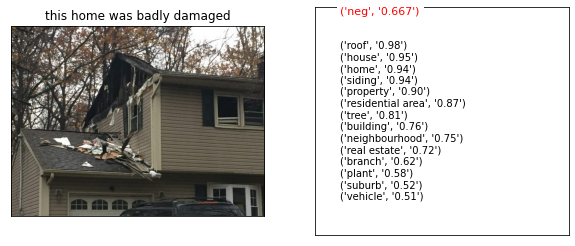

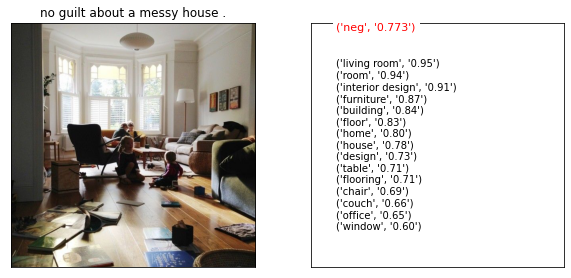

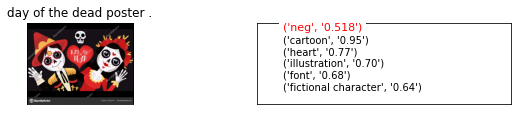

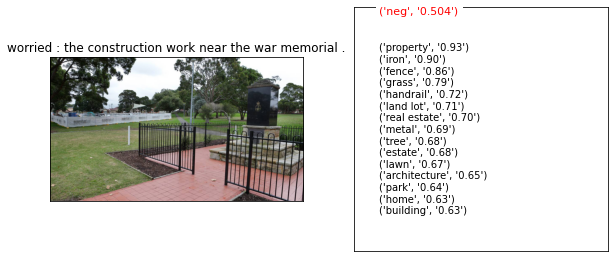

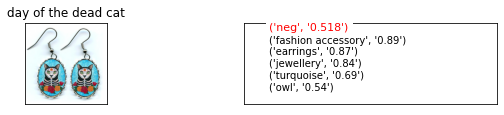

In [53]:
display_samples_with_hf_label(image_captions,'neg',conf_thresh=0.5,sent_class_col='nltk_sent_pos_neg',sent_conf_col='nltk_sent_pos_neg_conf')

### Huggingface's pretrained classifier

In [54]:

from transformers import pipeline


In [55]:
hf_sent = pipeline('sentiment-analysis')


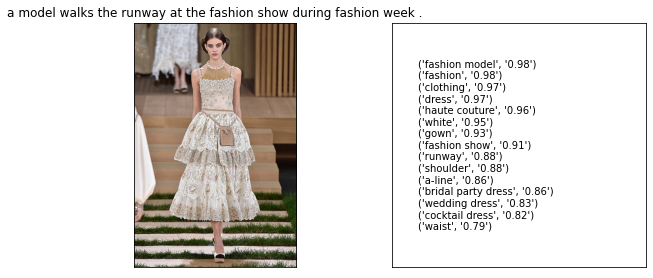

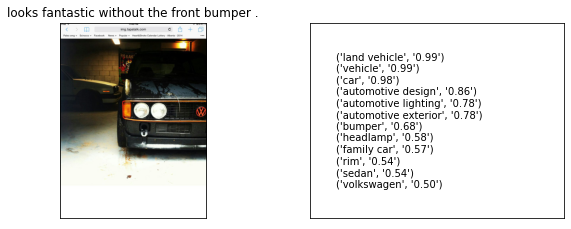

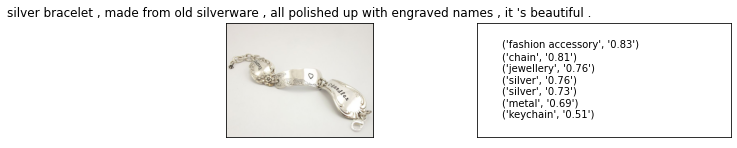

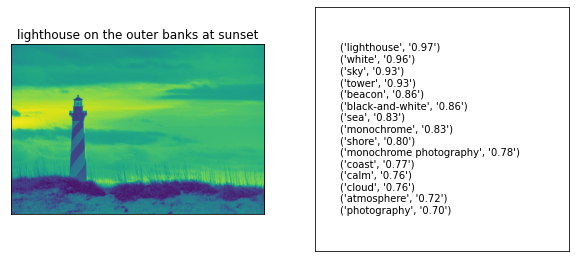

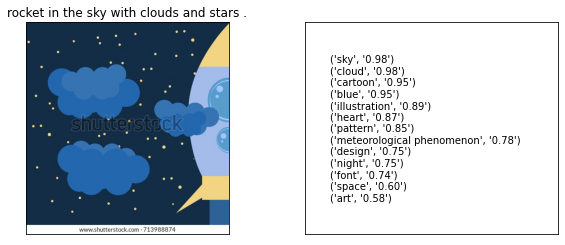

In [56]:
#example on random captions

random_sample = image_captions.sample(n=50, random_state=0)
#display 45 of the random samples
display_samples(random_sample)

In [57]:
random_sample['hf_sent'] = random_sample['caption'].apply(lambda x: hf_sent(x))
random_sample['hf_sent_label'] = random_sample['hf_sent'].apply(lambda x: x[0]['label'])
random_sample['hf_sent_label'].value_counts()
#looks a bit more divided!

POSITIVE    36
NEGATIVE    14
Name: hf_sent_label, dtype: int64

In [58]:
image_captions['hf_sent'] = image_captions['caption'].apply(lambda x: hf_sent(x))

In [59]:
image_captions['hf_sent_class'] = image_captions['hf_sent'].apply(lambda x: x[0]['label'])
image_captions['hf_sent_conf'] = image_captions['hf_sent'].apply(lambda x: x[0]['score'])

In [60]:
image_captions['hf_sent_class'].describe()

count        29928
unique           2
top       POSITIVE
freq         21016
Name: hf_sent_class, dtype: object

In [61]:
image_captions['hf_sent_class'].value_counts()/sum(image_captions['hf_sent_class'].value_counts())

POSITIVE    0.702219
NEGATIVE    0.297781
Name: hf_sent_class, dtype: float64

<AxesSubplot:>

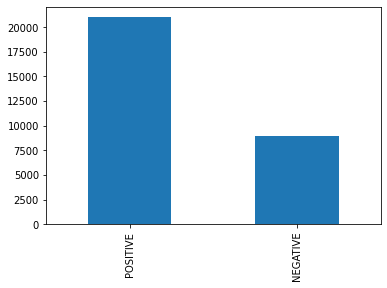

In [62]:
image_captions['hf_sent_class'].value_count
s().plot(kind = 'bar')

In [63]:
image_captions['hf_sent_conf'].describe() 

count    29928.000000
mean         0.949758
std          0.099335
min          0.500080
25%          0.960500
50%          0.993015
75%          0.998479
max          0.999891
Name: hf_sent_conf, dtype: float64

Looks a bit more balanced using huggingface!

### Huggingface caption confidence thresholds

<AxesSubplot:ylabel='Frequency'>

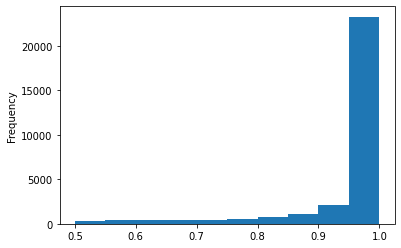

In [66]:


image_captions['hf_sent_conf'].plot.hist()

In [67]:
q = np.linspace(.1, 1, 9, 0)
image_captions['hf_sent_conf'].quantile(q)

0.1    0.826944
0.2    0.939430
0.3    0.973301
0.4    0.986978
0.5    0.993015
0.6    0.996132
0.7    0.997894
0.8    0.998930
0.9    0.999570
Name: hf_sent_conf, dtype: float64

As we can see, only 10% of the data has confidence under 80% - We are dealing with high confidence labels here!

As we can see, only 10% of the data has confidence under 80% - We are dealing with high confidence labels here!

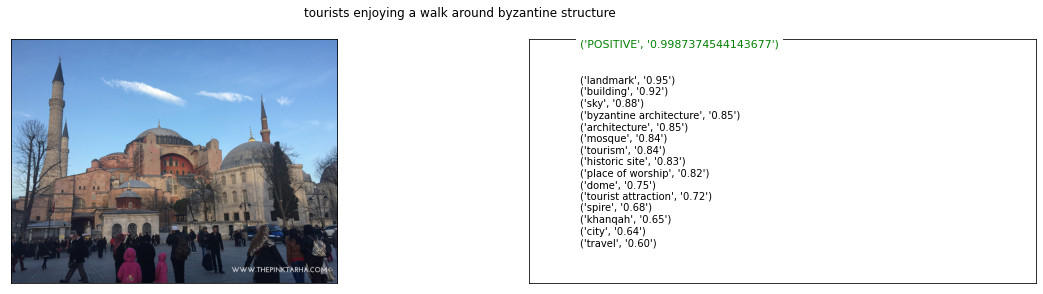

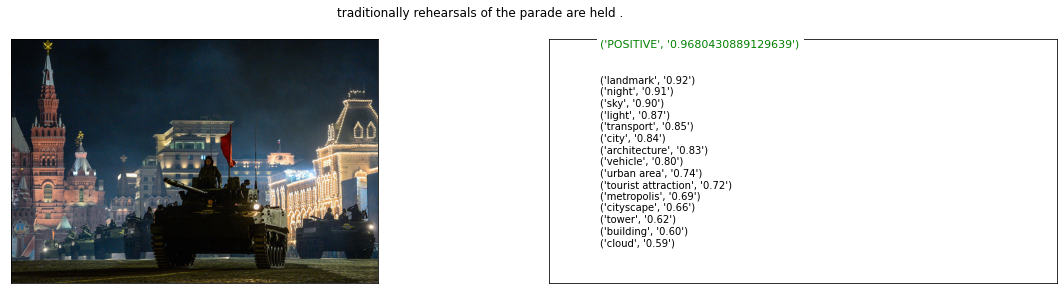

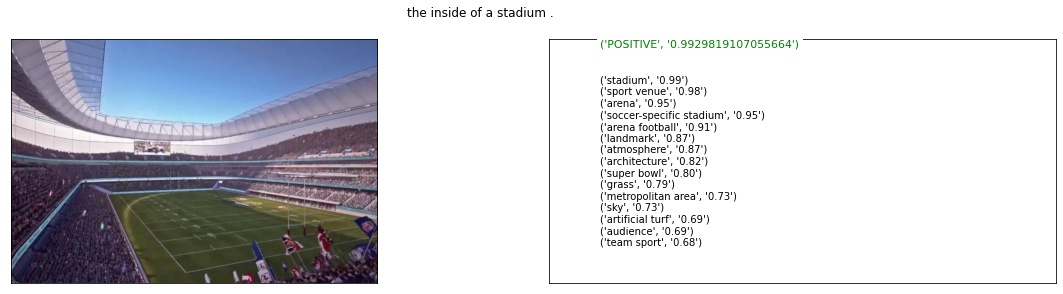

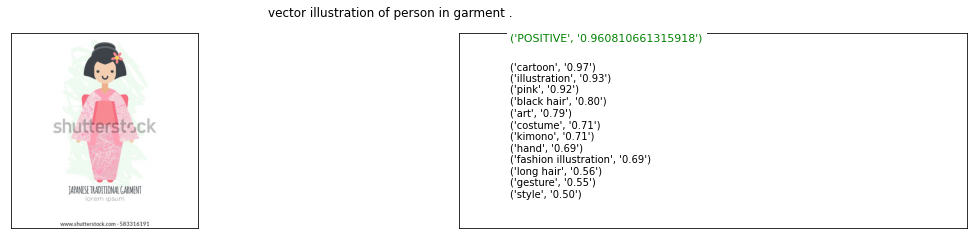

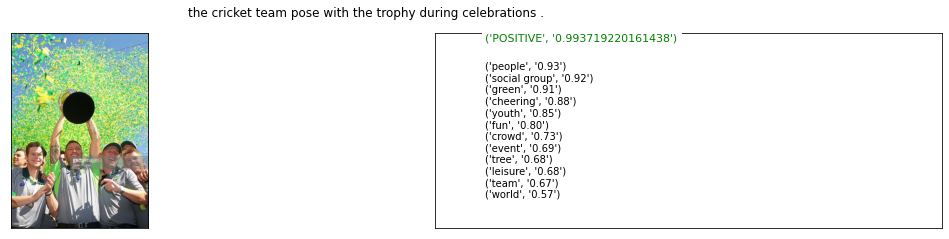

In [79]:
display_samples_with_hf_label(image_captions, "POSITIVE")


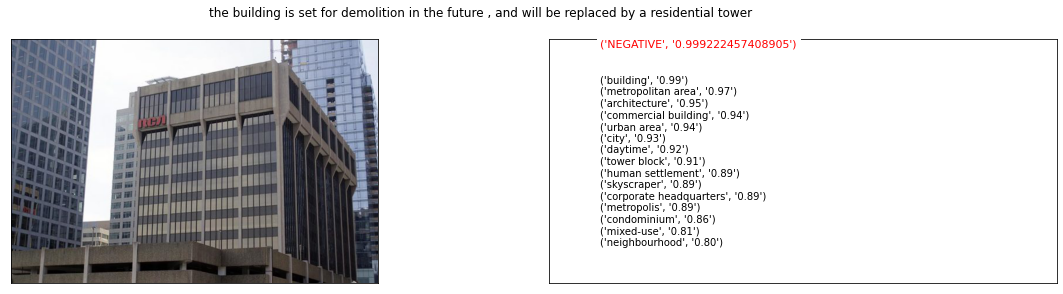

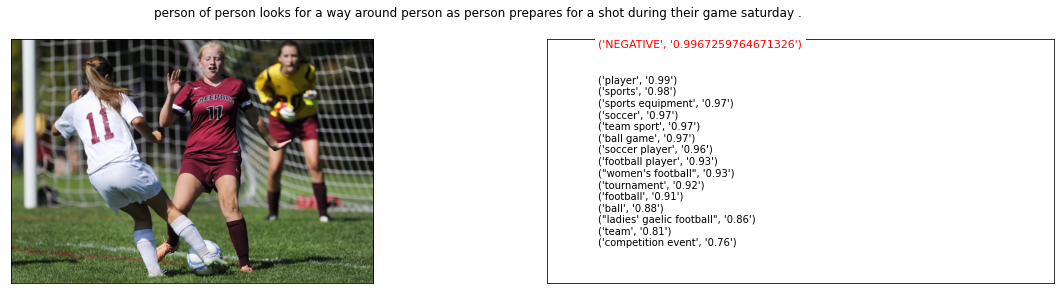

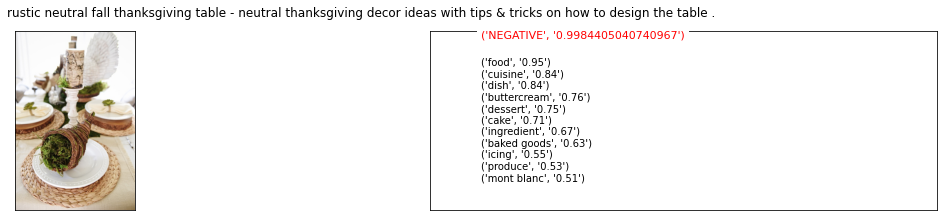

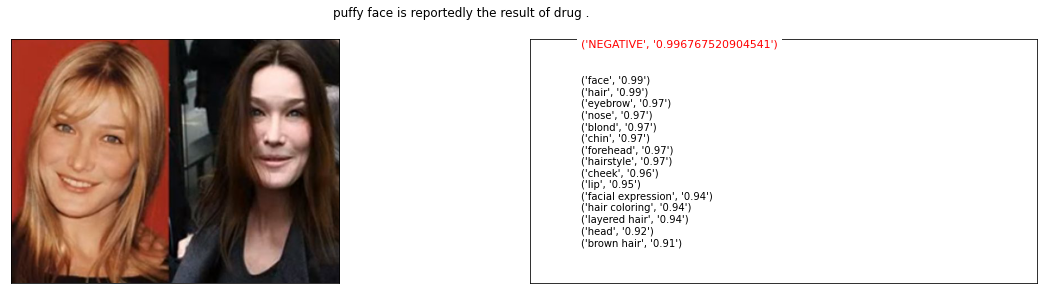

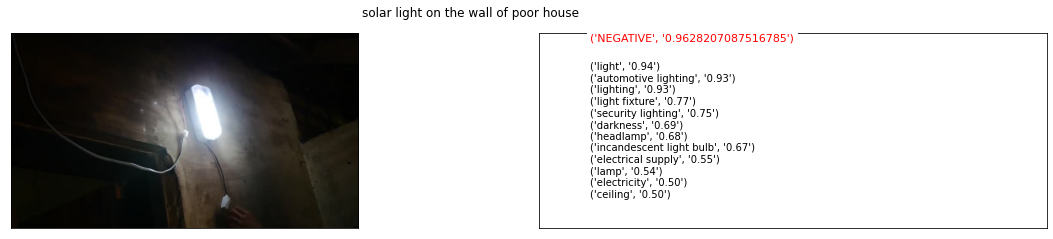

In [80]:
display_samples_with_hf_label(image_captions, "NEGATIVE")


In [81]:
print(image_captions.columns)

Index(['global_index', 'caption', 'link', 'objects', 'mid',
       'object_confidences', 'image_path', 'size', 'height', 'width',
       'aspect_ratio', 'num_obj', 'nltk_sent_polarity', 'nltk_sent',
       'nltk_sent_pos_neg', 'nltk_sent_pos_neg_conf', 'hf_sent',
       'hf_sent_class', 'hf_sent_conf'],
      dtype='object')


In [86]:
##Lets save all this info to use in a later stage
data_path = os.path.join('data', data_dir)
sent_path = os.path.join(data_path,'sent_added')
#if(not os.exists(sent_path))
image_captions.to_csv(sent_path,index=False)